# California Housing Prices

In this notebook, we analyzed a set of data consisting of median house prices for California. Using the data we obtained prediction error values.

## Initial Imports

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from pathlib import Path
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats

## Read CSV and Perform Basic Data Cleaning

In [36]:
# Load the data
file_path = Path('Resources/california_housing_prices.csv')
df = pd.read_csv(file_path)

# Preview the data
df

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  households  median_income  median_house_value  \
0           322.0       126.0         8.3252            452600.0   
1          2401.0      1138.0         8.3014            358500.0   
2           496.0       177.0         7.2574            352100.0   
3           558.0       219.0         5.6431            341300.0   
4           565.0       259.0         3.8462            342200.0   
...           ...         ...            ...                 ...   
20635       845.0       330.0         1.5603             78100.0   
20636       356.0       114.0         2.5568             77100.0   
20637      1007.0       433.0         1.7000             92300.0   
20638       741.0       349.0         1.8672             84700.0   
20639      1387.0       530.0         2.3886             89400.0   

      ocean_proximity  
0            NEAR BAY  
1            NEAR BAY  
2            NEAR BAY  
3            NEAR BAY  
4            NEAR BAY  
...               ...  
20635          INLAND  
20636          INLAND  
20637          INLAND  
20638          INLAND  
20639          INLAND  

[20640 rows x 10 columns]

In [37]:
# Drop nulls
df = df.dropna().copy()
df.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [7]:
# Get a summary of all features in the data and their types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [38]:
# To see how many subsets there are in "Ocean Proximity" column
df.ocean_proximity.value_counts()

<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
ISLAND           5
Name: ocean_proximity, dtype: int64

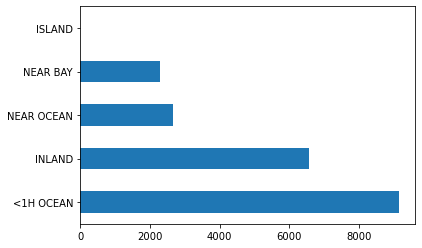

In [10]:
df.ocean_proximity.value_counts().sort_values(ascending=False).plot.barh()

In [39]:
# Descriptive statistics
df.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20433.000000  20433.000000        20433.000000  20433.000000   
mean    -119.570689     35.633221           28.633094   2636.504233   
std        2.003578      2.136348           12.591805   2185.269567   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1450.000000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.720000           37.000000   3143.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20433.000000  20433.000000   20433.000000   
mean       537.870553   1424.946949    499.433465       3.871162   
std        421.385070   1133.208490    382.299226       1.899291   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563700   
50%        435.000000   1166.000000    409.000000       3.536500   
75%        647.000000   1722.000000    604.000000       4.744000   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20433.000000  
mean        206864.413155  
std         115435.667099  
min          14999.000000  
25%         119500.000000  
50%         179700.000000  
75%         264700.000000  
max         500001.000000

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

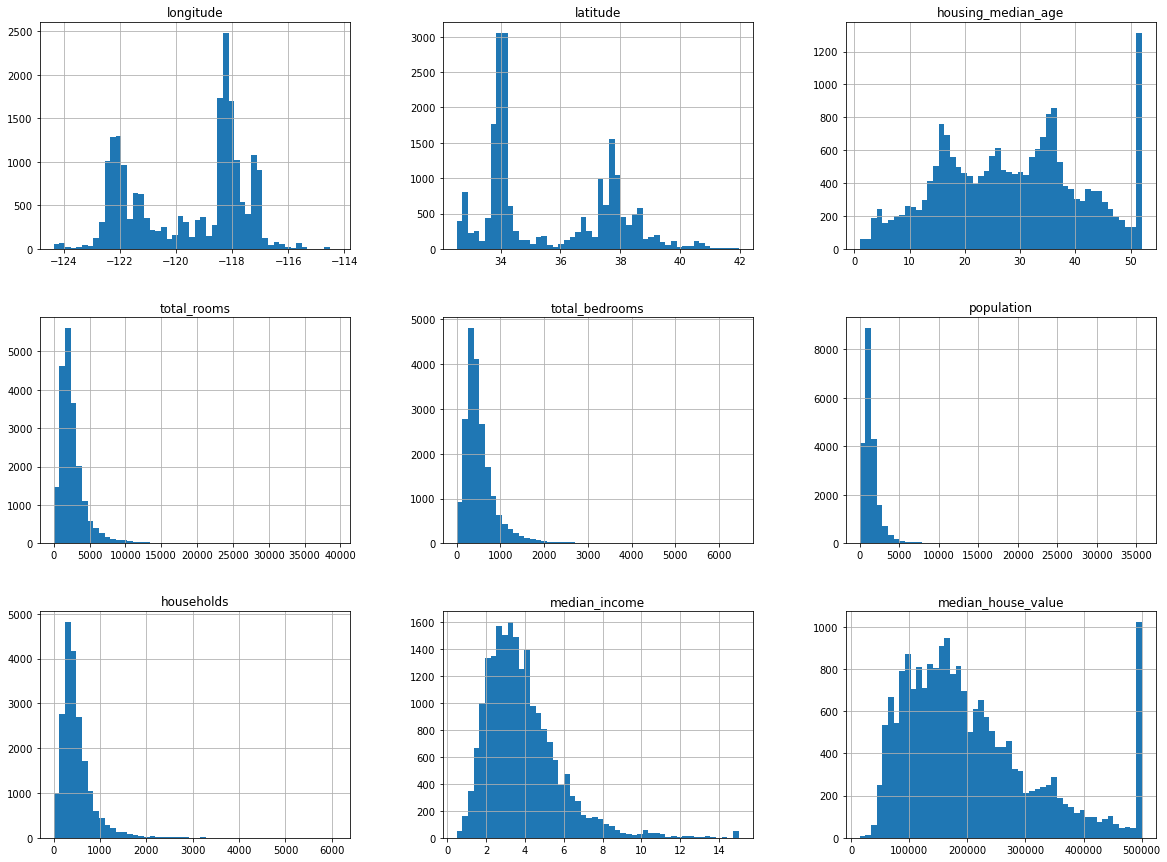

In [40]:
# Plotting a histogram for each numerical attribute
df.hist(bins=50, figsize=(20,15))

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

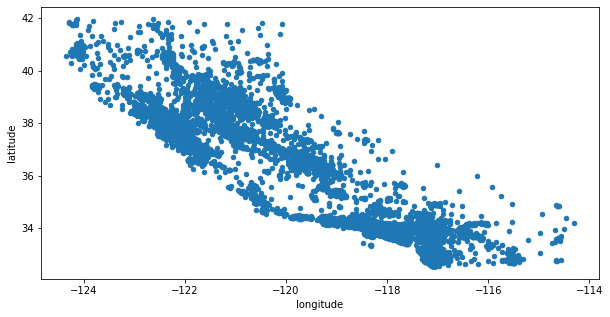

In [41]:
# Visualizing Geographical Data
df.plot(kind='scatter', x='longitude', y='latitude', figsize=(10,5))

<AxesSubplot:>

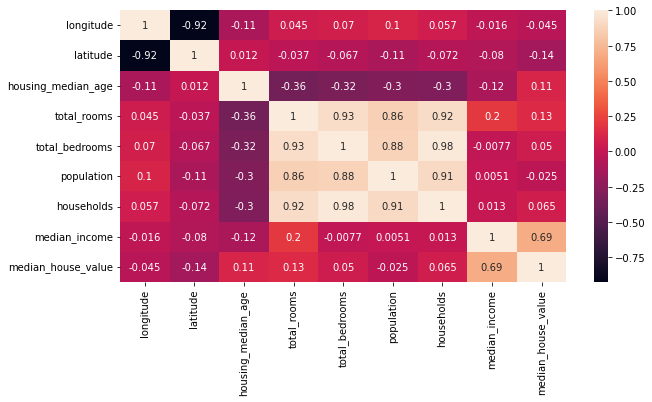

In [42]:
# Exploring the correlations in the data set
plt.figure(figsize=(10, 5))
sns.heatmap(df.corr(), annot=True)

#### Filling in missing values

In [14]:
# Return the number of missing values in each column
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [15]:
# Replace the null values with an average specified value
df['total_bedrooms'].fillna(df['total_bedrooms'].mean(),inplace=True)

In [46]:
num_imputer = SimpleImputer(strategy = 'mean')

imputer = ColumnTransformer([('num_imputer',num_imputer,['total_bedrooms'])])

total_bedrooms= imputer.fit_transform(df)

In [48]:
df['total_bedrooms'] = total_bedrooms

total_bedrooms

array([[ 129.],
       [1106.],
       [ 190.],
       ...,
       [ 485.],
       [ 409.],
       [ 616.]])

In [18]:
# Correlations
df_correlations = df.corr()
df_correlations

longitude  latitude  housing_median_age  total_rooms  \
longitude            1.000000 -0.924664           -0.108197     0.044568   
latitude            -0.924664  1.000000            0.011173    -0.036100   
housing_median_age  -0.108197  0.011173            1.000000    -0.361262   
total_rooms          0.044568 -0.036100           -0.361262     1.000000   
total_bedrooms       0.069260 -0.066658           -0.318998     0.927253   
population           0.099773 -0.108785           -0.296244     0.857126   
households           0.055310 -0.071035           -0.302916     0.918484   
median_income       -0.015176 -0.079809           -0.119034     0.198050   
median_house_value  -0.045967 -0.144160            0.105623     0.134153   

                    total_bedrooms  population  households  median_income  \
longitude                 0.069260    0.099773    0.055310      -0.015176   
latitude                 -0.066658   -0.108785   -0.071035      -0.079809   
housing_median_age       -0.318998   -0.296244   -0.302916      -0.119034   
total_rooms               0.927253    0.857126    0.918484       0.198050   
total_bedrooms            1.000000    0.873910    0.974725      -0.007682   
population                0.873910    1.000000    0.907222       0.004834   
households                0.974725    0.907222    1.000000       0.013033   
median_income            -0.007682    0.004834    0.013033       1.000000   
median_house_value        0.049454   -0.024650    0.065843       0.688075   

                    median_house_value  
longitude                    -0.045967  
latitude                     -0.144160  
housing_median_age            0.105623  
total_rooms                   0.134153  
total_bedrooms                0.049454  
population                   -0.024650  
households                    0.065843  
median_income                 0.688075  
median_house_value            1.000000

In [19]:
df_correlations['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049454
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

In [20]:
# Create new features and check their correlations
df['rooms_per_house'] = df['total_rooms']/df['households']
df['population_per_house'] = df['population']/df['households']

In [21]:
df.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  \
0       322.0       126.0         8.3252            452600.0        NEAR BAY   
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY   
2       496.0       177.0         7.2574            352100.0        NEAR BAY   
3       558.0       219.0         5.6431            341300.0        NEAR BAY   
4       565.0       259.0         3.8462            342200.0        NEAR BAY   

   rooms_per_house  population_per_house  
0         6.984127              2.555556  
1         6.238137              2.109842  
2         8.288136              2.802260  
3         5.817352              2.547945  
4         6.281853              2.181467

In [22]:
df_corr = df.corr()
df_corr['median_house_value'].sort_values(ascending=False)

median_house_value      1.000000
median_income           0.688075
rooms_per_house         0.151948
total_rooms             0.134153
housing_median_age      0.105623
households              0.065843
total_bedrooms          0.049454
population_per_house   -0.023737
population             -0.024650
longitude              -0.045967
latitude               -0.144160
Name: median_house_value, dtype: float64

In [49]:
# Category variable
ocean_prox = pd.get_dummies(df['ocean_proximity'])
ocean_prox.head()

<1H OCEAN  INLAND  ISLAND  NEAR BAY  NEAR OCEAN
0          0       0       0         1           0
1          0       0       0         1           0
2          0       0       0         1           0
3          0       0       0         1           0
4          0       0       0         1           0

In [24]:
# Combining dataframe and variable
df = pd.concat([df, ocean_prox],axis = 1)
df.drop('ocean_proximity',axis = 1, inplace = True)
df.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value  rooms_per_house  \
0       322.0       126.0         8.3252            452600.0         6.984127   
1      2401.0      1138.0         8.3014            358500.0         6.238137   
2       496.0       177.0         7.2574            352100.0         8.288136   
3       558.0       219.0         5.6431            341300.0         5.817352   
4       565.0       259.0         3.8462            342200.0         6.281853   

   population_per_house  <1H OCEAN  INLAND  ISLAND  NEAR BAY  NEAR OCEAN  
0              2.555556          0       0       0         1           0  
1              2.109842          0       0       0         1           0  
2              2.802260          0       0       0         1           0  
3              2.547945          0       0       0         1           0  
4              2.181467          0       0       0         1           0

## Split the Data into Training and Testing

In [25]:
# Create features
X = df.drop('median_house_value', axis=1)

# Create target vector
y = df['median_house_value']

In [50]:
# Check the balance of our target values
y.value_counts()

500001.0    965
137500.0    122
162500.0    117
112500.0    103
187500.0     93
           ... 
359200.0      1
54900.0       1
377600.0      1
81200.0       1
47000.0       1
Name: median_house_value, Length: 3842, dtype: int64

In [53]:
# Split the X and y into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state = 42
)

X_train.shape

(16512, 15)

In [27]:
# Use the MinMaxScaler to scale data between 0 and 1
scaler = MinMaxScaler()


# Fitting MinMaxScaler instance
X = scaler.fit_transform(X)
X[0:5]

array([[0.21115538, 0.5674814 , 0.78431373, 0.02233074, 0.01986344,
        0.00894083, 0.02055583, 0.53966842, 0.0435123 , 0.00149943,
        0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.21215139, 0.565356  , 0.39215686, 0.18050257, 0.17147734,
        0.0672104 , 0.18697583, 0.53802706, 0.03822395, 0.00114074,
        0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.21015936, 0.5642933 , 1.        , 0.03726029, 0.02932961,
        0.01381765, 0.02894261, 0.46602805, 0.05275646, 0.00169796,
        0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.20916335, 0.5642933 , 1.        , 0.03235159, 0.03631285,
        0.01555537, 0.03584937, 0.35469856, 0.03524099, 0.0014933 ,
        0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.20916335, 0.5642933 , 1.        , 0.04132967, 0.04329609,
        0.01575156, 0.04242723, 0.23077613, 0.03853386, 0.00119838,
        0.        , 0.        , 0.        , 

## Model Evaluation

#### Evaluating metrics with Cross Validation

In [61]:
def score_display(scores):
    scores = np.sqrt(-scores)
    print(f"""
    RMSE Scores : {scores}
    Mean : {scores.mean()}
    Standart Deviation : {scores.std()}
    """)

In [62]:
linreg = LinearRegression()
DecTree = DecisionTreeRegressor()
RandForest = RandomForestRegressor()
SVM = SVR()

In [71]:
# Linear Regression
linreg_scores = cross_val_score(
    linreg,
    X_train,
    y_train,
    scoring = 'neg_mean_squared_error',
    cv=10
)

score_display(linreg_scores)


    RMSE Scores : [65601.01689098 71627.20418119 68038.38722887 66987.28199265
 69394.1236065  66115.0624049  65908.87195323 69281.69706496
 72885.82145152 69751.44015401]
    Mean : 68559.0906928804
    Standart Deviation : 2350.8276319965557
    


In [72]:
# Decision Tree
DecTree_scores = cross_val_score(
    DecTree,
    X_train,
    y_train,
    scoring = 'neg_mean_squared_error',
    cv=10
)

score_display(DecTree_scores)


    RMSE Scores : [65573.09155342 68911.18453865 71414.72104626 71323.16750662
 73294.07598073 67766.00909671 68295.74562727 68622.32411075
 68544.04899047 69984.49644127]
    Mean : 69372.88648921462
    Standart Deviation : 2082.467077448206
    


In [73]:
# Random Forest
RandForest_scores = cross_val_score(
    RandForest,
    X_train,
    y_train,
    scoring = 'neg_mean_squared_error',
    cv=10
)

score_display(RandForest_scores)


    RMSE Scores : [46767.36888077 51629.85668954 49813.43779447 52038.98157901
 52374.38830878 47165.98448046 47479.90405267 50793.30600592
 49453.12123648 49976.14163839]
    Mean : 49749.24906665031
    Standart Deviation : 1939.5632297970913
    


In [74]:
# Support Vector Machine
SVM_scores = cross_val_score(
    SVM,
    X_train,
    y_train,
    scoring = 'neg_mean_squared_error',
    cv=10
)

score_display(SVM_scores)


    RMSE Scores : [119094.47159265 121011.36551495 119205.7932461  114116.91854659
 117888.00142989 119295.72248473 115643.65508969 116473.4672355
 119250.75317175 119797.05656486]
    Mean : 118177.72048767065
    Standart Deviation : 2021.1507462108714
    


RandomForest has the lowest Root Mean Squared Error.

## Parameter Optimization

#### GridSearchCV

Helps to loop through predefined hyperparameters and fit your estimator (model) on your training set. So, in the end, you can select the best parameters from the listed hyperparameters.

In [75]:
params = {
    'n_estimators': [3, 10, 20, 50], 
    'max_features': [2, 3, 4, 10]
}

In [78]:
grid_search = GridSearchCV(
    RandForest,
    params, 
    cv=5,
    scoring='neg_mean_squared_error'
)

In [79]:
# Fitting data into GridSearchCV
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': [2, 3, 4, 10],
                         'n_estimators': [3, 10, 20, 50]},
             scoring='neg_mean_squared_error')

In [80]:
# Best results on the held out data
grid_search.best_params_

{'max_features': 4, 'n_estimators': 50}

In [82]:
for mean_score,params in zip(
    (grid_search.cv_results_['mean_test_score']),
    (grid_search.cv_results_['params'])
):    
    
    print(np.sqrt(-mean_score),'    ',params)

62723.02369655602      {'max_features': 2, 'n_estimators': 3}
54405.71548304711      {'max_features': 2, 'n_estimators': 10}
52832.00266799951      {'max_features': 2, 'n_estimators': 20}
51443.69218897462      {'max_features': 2, 'n_estimators': 50}
60328.847592393395      {'max_features': 3, 'n_estimators': 3}
52702.07586430306      {'max_features': 3, 'n_estimators': 10}
51140.40745750642      {'max_features': 3, 'n_estimators': 20}
49885.68295335053      {'max_features': 3, 'n_estimators': 50}
59540.62954414431      {'max_features': 4, 'n_estimators': 3}
52426.23644444778      {'max_features': 4, 'n_estimators': 10}
50369.44301587852      {'max_features': 4, 'n_estimators': 20}
49264.972302367205      {'max_features': 4, 'n_estimators': 50}
58567.60533232593      {'max_features': 10, 'n_estimators': 3}
52194.62322344519      {'max_features': 10, 'n_estimators': 10}
50799.83543166272      {'max_features': 10, 'n_estimators': 20}
49515.87862612662      {'max_features': 10, 'n_estimat

In [83]:
# Making predictions using the best estimator
predictions = grid_search.best_estimator_.predict(X_test)

In [84]:
y_test[0:10].values

array([ 47700.,  45800., 500001., 218600., 278000., 158700., 198200.,
       157500., 340000., 446600.])

In [85]:
# Comparing real versus predicted values
comparison = pd.DataFrame(
    {'Y Test': y_test[0:10].values,
    'Predictions' : predictions[0:10]}
)
comparison

Y Test  Predictions
0   47700.0     50062.00
1   45800.0     75156.00
2  500001.0    468098.62
3  218600.0    254798.00
4  278000.0    230156.00
5  158700.0    153612.00
6  198200.0    229394.02
7  157500.0    172942.00
8  340000.0    297786.06
9  446600.0    471484.56

<AxesSubplot:title={'center':'Real vs Predicted Values'}>

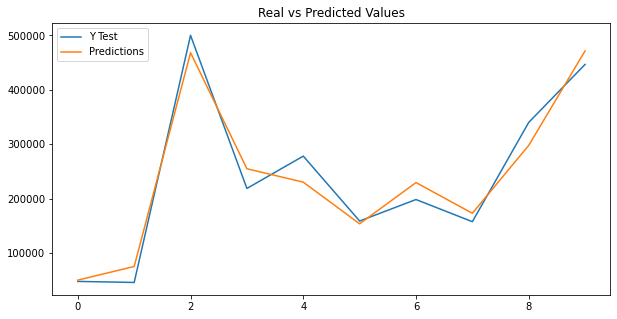

In [101]:
# Plot the real vs predicted values as a line chart
comparison.plot(title= 'Real vs Predicted Values', figsize= (10,5))

## Evaluations

In [89]:
def regression_evaluation(preds):
    mse = mean_squared_error(y_test,preds)
    rmse = np.sqrt(mse)
    r_squared = r2_score(y_test,preds)
    mae = mean_absolute_error(y_test,preds)
    
    print(f"Mean Absolute Error: {mae} \nMean Squared Error:{mse} \nRoot Mean Squared Error:{rmse} \nR Squared Value:{r_squared}")

In [90]:
regression_evaluation(predictions)

Mean Absolute Error: 32110.13673449612 
Mean Squared Error:2386841599.041903 
Root Mean Squared Error:48855.312904963605 
R Squared Value:0.8178552162969752


## Confidence Interval

In [91]:
# Finding the Confidence Interval Of 95%
confidence = 0.95
squared_errors = (predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
loc=squared_errors.mean(),
scale=stats.sem(squared_errors))) 

array([46656.44259578, 50959.3913071 ])

The model can predict with the error values between 46,656.44 and 50,959.39.